In [1]:
import pandas as pd
import numpy as np
import os, sys
from plot_utils.utils import *
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

DIR = '/Users/user/Documents/Archive Grégoire/greg stage/results'
DIR_RES = '/Users/user/Documents/Archive Grégoire/greg stage/results/res'
DIR_AGG = '/Users/user/Documents/Archive Grégoire/greg stage/results/agg'
DIR_AGG_R = '/Users/user/Documents/Archive Grégoire/greg stage/profoagg/results'
DF_DOC = pd.read_excel('/Users/user/Documents/Archive Grégoire/greg stage/results/res_doc.xlsx')
sns.set_style('whitegrid')

In [9]:
def reorder_quantiles(df):
    df = df.sort_values(by=['Date', 'Hour', 'model', 'quantile'])
    dfp = pd.pivot_table(df, values='SpotPrice_pred', index=['model', 'Date', 'Hour', 'SpotPrice'],
                         columns='quantile')
    dfp.columns = np.sort(dfp.columns)
    dfp.iloc[:, :] = np.sort(dfp, axis=1)
    df = pd.melt(dfp.reset_index(), id_vars=['model', 'Date', 'Hour', 'SpotPrice'], var_name='quantile',
                 value_name='SpotPrice_pred')
    df = df.sort_values(by=['Date', 'Hour', 'model', 'quantile'])
    return df


def evaluate_quantile_pred_modif(df_pred, alpha, start=None, end=None, plot=False, hue='model_name', style='model_style', palette=None, **kwargs):
    ylim1 = kwargs.pop('ylim1') if 'ylim1' in kwargs else (0,100)
    ylim2 = kwargs.pop('ylim2') if 'ylim2' in kwargs else (0,50)
    
    start = df_pred.Date.min() if start is None else start
    end = df_pred.Date.max() if end is None else end
    df_quantile_scores = pd.DataFrame()

    for a in tqdm(alpha):
        assert a != 0, "Cannot compute quantile score for median prediction, Please use RMSE"
        q_up, q_down = round(100 * (a + 1) / 2, 2), round(100 * (1 - a) / 2, 2)

        for hue_val in df_pred[hue].unique():
            for style_val in df_pred[style].unique():
                df_to_score = df_pred[(df_pred[hue] == hue_val) &
                                      (df_pred[style] == style_val) &
                                      (df_pred['quantile'].isin([q_up, q_down])) &
                                      (df_pred.Date >= start) &
                                      (df_pred.Date <= end)
                                      ]
                if len(df_to_score) > 0:

                    y_true = df_to_score[df_to_score['quantile'] == q_up].SpotPrice.reset_index(drop=True)
                    y_high = df_to_score[df_to_score['quantile'] == q_up].SpotPrice_pred.reset_index(drop=True)
                    y_low = df_to_score[df_to_score['quantile'] == q_down].SpotPrice_pred.reset_index(drop=True)

                    emp_cov = empirical_coverage(y_true, y_low, y_high)
                    wr_score = wrinkler_score(y_true, y_low, y_high, alpha=a)
                    # unc_cov = unconditional_coverage(y_true, y_low, y_high, alpha=a)
                    int_width = interval_width(y_low, y_high)

                    df_quantile_scores = df_quantile_scores.append(
                        pd.DataFrame({
                            hue : df_to_score[hue].iloc[0],
                            style : df_to_score[style].iloc[0],
                            'alpha': [a],
                            'empirical_coverage': [emp_cov- a],
                            'wrinkler_score': [wr_score],
                            # 'unconditional_coverage': [unc_cov], # TODO : Fix this score
                            'interval_width': [int_width]
                        })
                    )

    if plot:
        plot_quantile_pred(df_quantile_scores, hue, style, palette, **kwargs)
        return df_quantile_scores
        fig, axes = plt.subplots(1, 3)
        label_name = ['$\Delta_{coverage}$', 'Winkler score', "Interval width"]
        for i, score in enumerate(['empirical_coverage', 'wrinkler_score', 'interval_width']):

            sns.lineplot(
                data=df_quantile_scores.rename(columns={'alpha': 'target_coverage'}).reset_index(),
                x='target_coverage',
                y=score,
                hue=hue,
                style=style,
                markers=True,
                ax=axes[i],
                palette=palette,
                **kwargs)
            axes[i].set_xlabel('Target coverage')
            axes[i].set_ylabel(label_name[i])

            if i < 2:
                axes[i].legend([])
            
            else:
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.5, 1))

            if score == 'empirical_coverage':
                axes[i].plot([0, 1], [0, 0], c='k')

        #axes[0].set_ylim((-0.1, 0.1))
        axes[1].set_ylim(ylim1)
        axes[2].set_ylim(ylim2)
        fig.set_size_inches((30, 10))

    return df_quantile_scores


def plot_quantile_pred(df_quantile_scores, hue, style, palette, **kwargs):
    ylim1 = kwargs.pop('ylim1') if 'ylim1' in kwargs else (0,100)
    ylim2 = kwargs.pop('ylim2') if 'ylim2' in kwargs else (0,50)
    
    fig, axes = plt.subplots(1, 3)
    label_name = ['$\Delta_{coverage}$', 'Winkler score', "Interval width"]
    for i, score in enumerate(['empirical_coverage', 'wrinkler_score', 'interval_width']):

        sns.lineplot(
            data=df_quantile_scores.rename(columns={'alpha': 'target_coverage'}).reset_index(),
            x='target_coverage',
            y=score,
            hue=hue,
            style=style,
            markers=True,
            ax=axes[i],
            palette=palette,
            **kwargs)
        axes[i].set_xlabel('Target coverage')
        axes[i].set_ylabel(label_name[i])

        if i < 2:
            axes[i].legend([])

        else:
            axes[i].legend(loc='upper right', bbox_to_anchor=(1.5, 1))

        if score == 'empirical_coverage':
            axes[i].plot([0, 1], [0, 0], c='k')

    #axes[0].set_ylim((-0.1, 0.1))
    axes[1].set_ylim(ylim1)
    axes[2].set_ylim(ylim2)
    fig.set_size_inches((30, 10))
    

def evaluate_quantile_pred_2(df_pred, alpha, start=None, end=None, plot=False, hue='model_name', style='model_style', palette=None, **kwargs):
    #ylim1 = kwargs.pop('ylim1') if 'ylim1' in kwargs else (0,100)
    ylim2 = kwargs.pop('ylim2') if 'ylim2' in kwargs else (0,50)
    
    start = df_pred.Date.min() if start is None else start
    end = df_pred.Date.max() if end is None else end
    df_quantile_scores = pd.DataFrame()

    for a in tqdm(alpha):
        assert a != 0, "Cannot compute quantile score for median prediction, Please use RMSE"
        q_up, q_down = round(100 * (a + 1) / 2, 2), round(100 * (1 - a) / 2, 2)

        for hue_val in df_pred[hue].unique():
            for style_val in df_pred[style].unique():
                df_to_score = df_pred[(df_pred[hue] == hue_val) &
                                      (df_pred[style] == style_val) &
                                      (df_pred['quantile'].isin([q_up, q_down])) &
                                      (df_pred.Date >= start) &
                                      (df_pred.Date <= end)
                                      ]
                if len(df_to_score) > 0:

                    y_true = df_to_score[df_to_score['quantile'] == q_up].SpotPrice.reset_index(drop=True)
                    y_high = df_to_score[df_to_score['quantile'] == q_up].SpotPrice_pred.reset_index(drop=True)
                    y_low = df_to_score[df_to_score['quantile'] == q_down].SpotPrice_pred.reset_index(drop=True)

                    emp_cov = empirical_coverage(y_true, y_low, y_high)
                    #wr_score = wrinkler_score(y_true, y_low, y_high, alpha=a)
                    # unc_cov = unconditional_coverage(y_true, y_low, y_high, alpha=a)
                    int_width = interval_width(y_low, y_high)

                    df_quantile_scores = df_quantile_scores.append(
                        pd.DataFrame({
                            hue : df_to_score[hue].iloc[0],
                            style : df_to_score[style].iloc[0],
                            'alpha': [a],
                            'empirical_coverage': [emp_cov- a],
                            #'wrinkler_score': [wr_score],
                            # 'unconditional_coverage': [unc_cov], # TODO : Fix this score
                            'interval_width': [int_width]
                        })
                    )

    if plot:
        plot_quantile_pred_2(df_quantile_scores, hue, style, palette, **kwargs)
        return df_quantile_scores
        
        label_name = ['$\Delta_{coverage}$', "Interval width"]
        fig, axes = plt.subplots(1, 2)
        for i, score in enumerate(['empirical_coverage', 'interval_width']):

            sns.lineplot(
                data=df_quantile_scores.rename(columns={'alpha': 'target_coverage'}).reset_index(),
                x='target_coverage',
                y=score,
                hue=hue,
                style=style,
                markers=True,
                ax=axes[i],
                palette=palette,
                **kwargs)
            axes[i].set_xlabel('Target coverage')
            axes[i].set_ylabel(label_name[i])

            if i < 1:
                axes[i].legend([])
            
            else:
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.5, 1))

            if score == 'empirical_coverage':
                axes[i].plot([0, 1], [0, 0], c='k')

        #axes[0].set_ylim((-0.1, 0.1))
        axes[1].set_ylim(ylim2)
        fig.set_size_inches((30, 10))

    return df_quantile_scores

def plot_quantile_pred_2(df_quantile_scores, hue, style, palette, **kwargs):
    ylim2 = kwargs.pop('ylim2') if 'ylim2' in kwargs else (0,50)
    
    label_name = ['$\Delta_{coverage}$', "Interval width"]
    fig, axes = plt.subplots(1, 2)
    for i, score in enumerate(['empirical_coverage', 'interval_width']):

        sns.lineplot(
            data=df_quantile_scores.rename(columns={'alpha': 'target_coverage'}).reset_index(),
            x='target_coverage',
            y=score,
            hue=hue,
            style=style,
            markers=True,
            ax=axes[i],
            palette=palette,
            **kwargs)
        axes[i].set_xlabel('Target coverage')
        axes[i].set_ylabel(label_name[i])

        if i < 1:
            axes[i].legend([])

        else:
            axes[i].legend(loc='upper right', bbox_to_anchor=(1.5, 1))

        if score == 'empirical_coverage':
            axes[i].plot([0, 1], [0, 0], c='k')

    #axes[0].set_ylim((-0.1, 0.1))
    axes[1].set_ylim(ylim2)
    fig.set_size_inches((30, 10))
    
    
dic_colors = {
    'AgACI (CQRoj, 25 \% CAL)' : '#8D77FD',
    'AgACI (CQR, 25 \% CAL)' : "#380388",
    
    'CQRoj+ (25 \% CAL)' : "#151515",
    "CQR (25 \% CAL)" : "#A0A0A0",
    
    "ERF" : "#CC3232",
    "qGAM": "#9CF18F",
    
    "Gradient Boosting" : "#9E1988",
    #'GradientBoostingPER90' : "#E088B4",
    
    "Lasso": "#ABAB00",
    #'LassoQuantilePER90' : "#E6D679",

    "Linear" : "#04C3B5",
    #'LinQuantilePER180': "#A7EAEA",
    
    "QRF" : "#00108C",
    #'QuantileRandomForestRegressorPER90' : "#9598CE",
    
    #'BOAGAggregator_crps_no_cqr' : "#9CF18F",
    #'BOAGAggregator_no_cqr' : "#9CF18F",
    
    "BOAG Aggregation"  : "#009022",
    "BOAG Aggregation (CRPS)" : "#009022",

}

# Graph 1

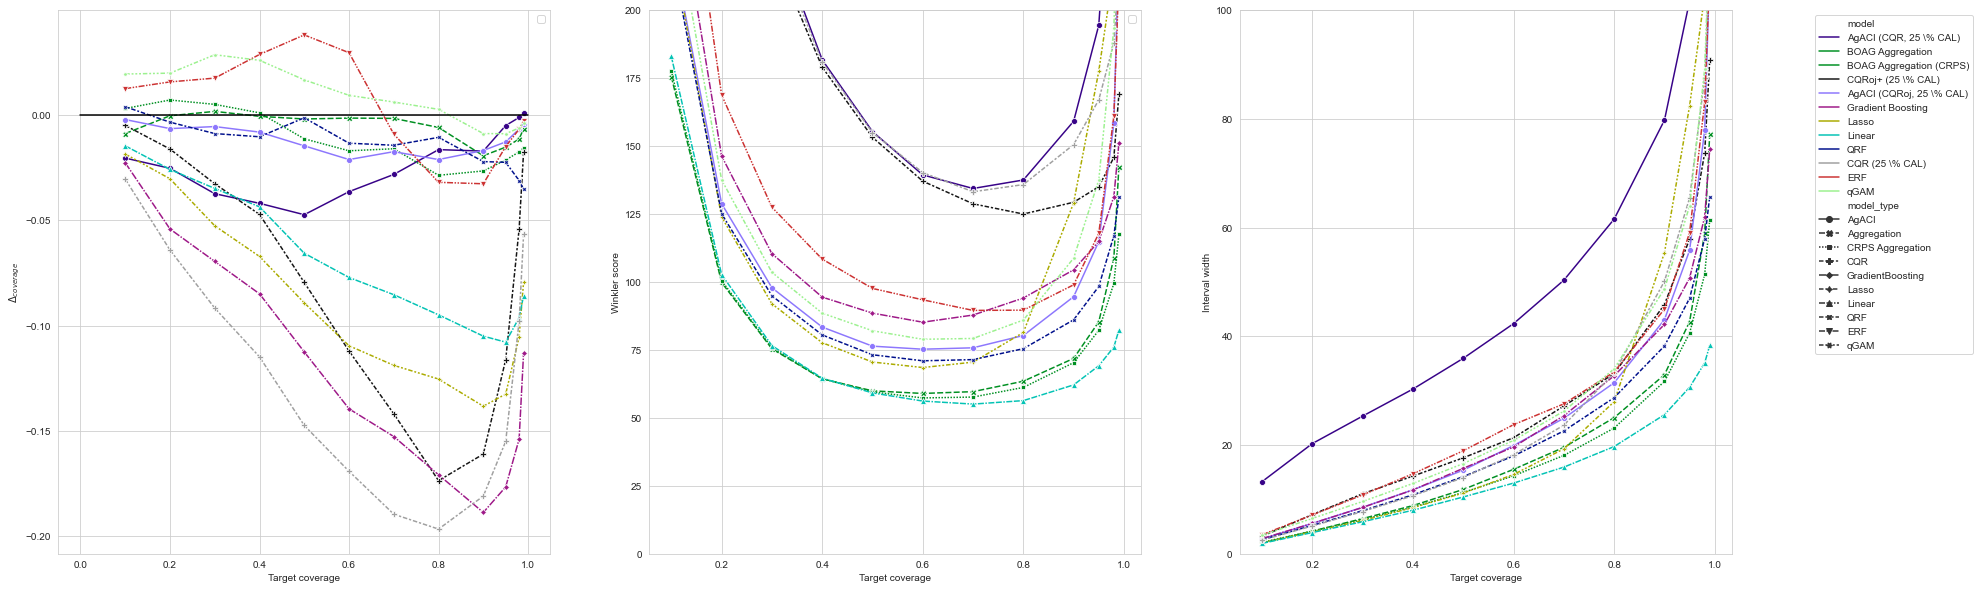

In [19]:
df_ = pd.read_csv('Data10.csv')
plot_quantile_pred(df_, hue='model',
                                  style='model_type',
                                  palette=dic_colors,
                                  ylim1 = (0, 200),
                                  ylim2 = (0, 100))

# Graph 2

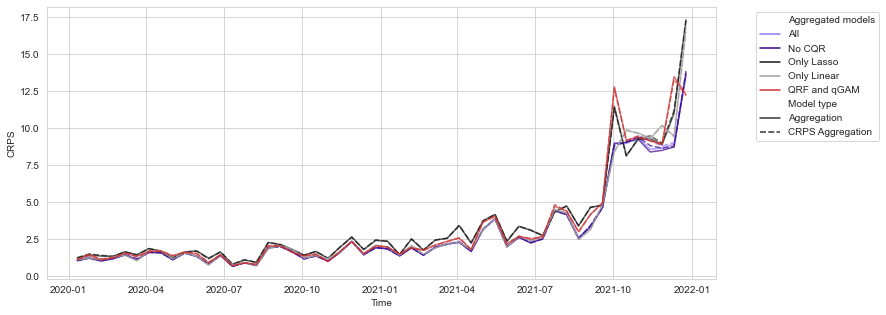

In [10]:
dfg = pd.read_csv("Data9.csv")
dfg["Time"] = pd.to_datetime(dfg.Time)

plt.figure(figsize=(12,5))
sns.lineplot(data=dfg.sort_values(by='Time').rename(columns ={'Models in' : 'Aggregated models', 'model_type' : 'Model type'}),
             x='Time',
             y='crps',
             hue='Aggregated models',
             style='Model type',
             palette =dic_colors.values(),
            linewidth=1.5, alpha=0.7)
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1))
plt.ylabel('CRPS')
plt.show()

# Graph 3

In [11]:
# pas disponible pour le moment

# Graph 4 & 5

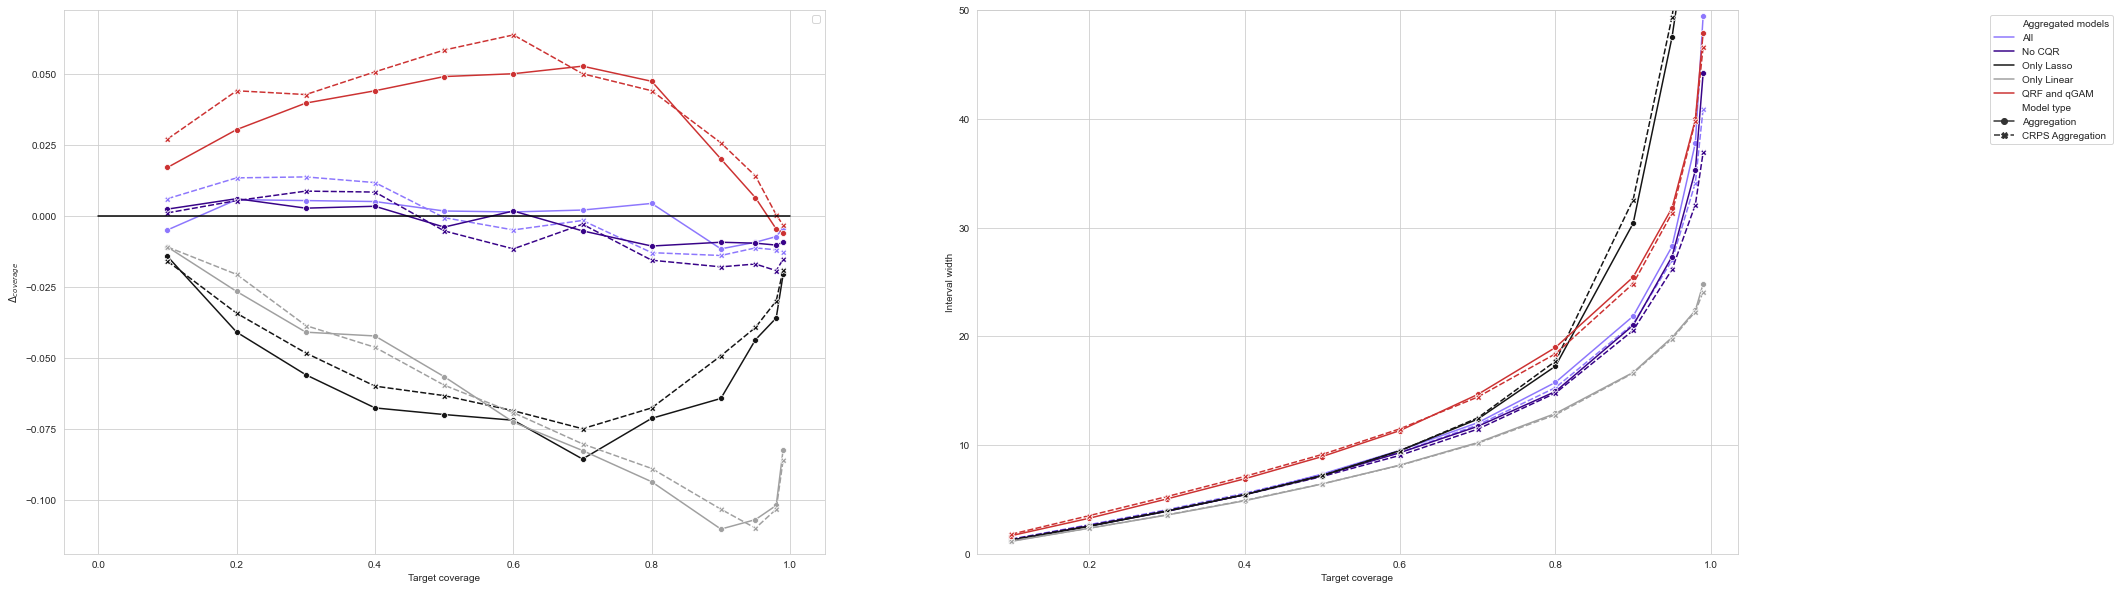

In [12]:
df_ = pd.read_csv('Data12.csv')
plot_quantile_pred_2(df_,
                    hue='Aggregated models',
                                  style='Model type',
                                  palette=dic_colors.values(),)

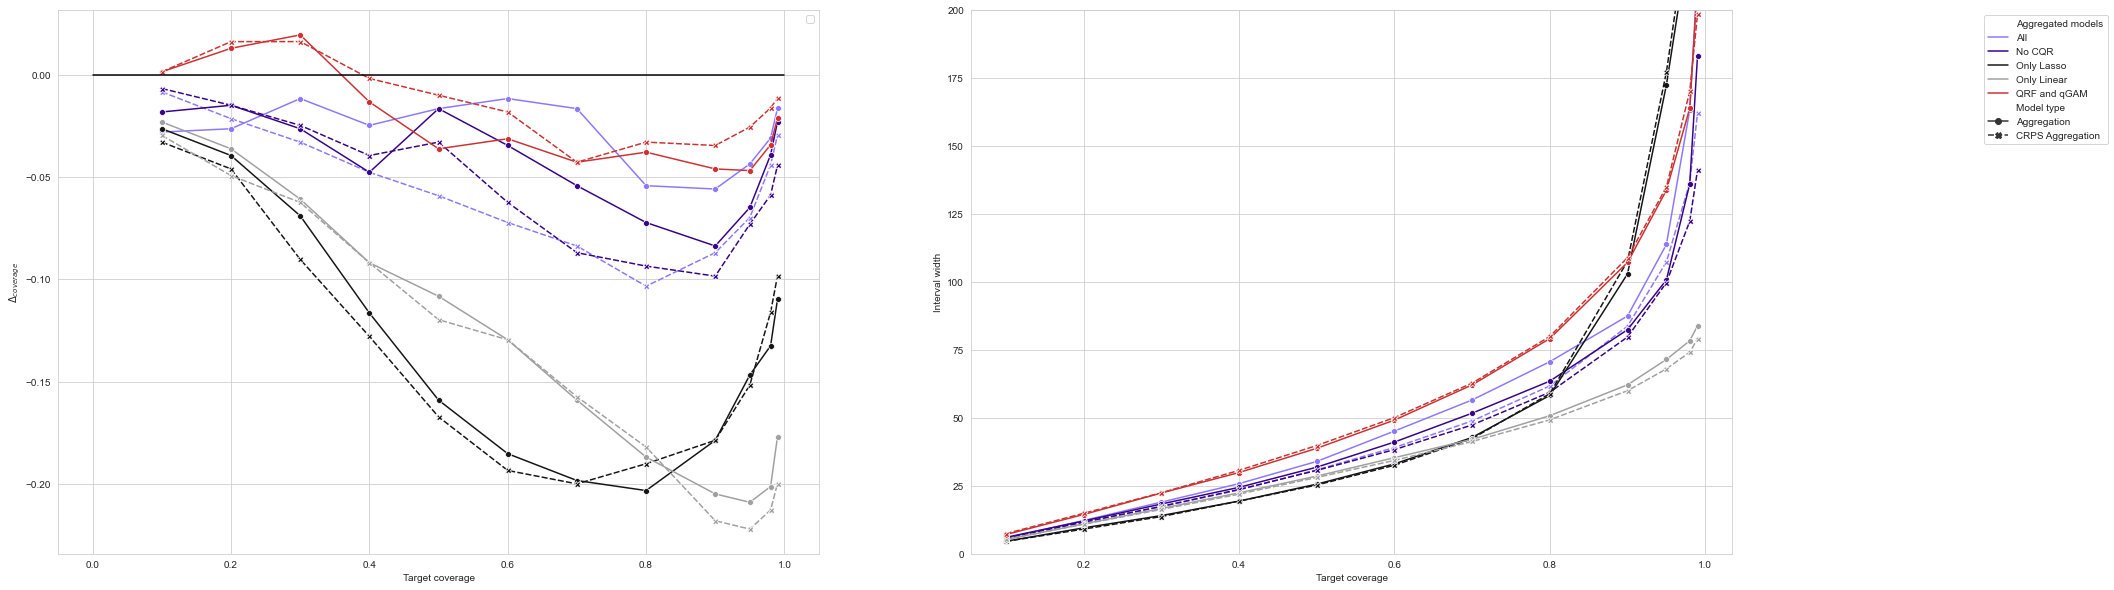

In [13]:
df_ = pd.read_csv('Data13.csv')
plot_quantile_pred_2(df_,
                    hue='Aggregated models',
                                  style='Model type',
                                  palette=dic_colors.values(),
                    ylim2=(0, 200),)

# Graph 6 & 7

In [14]:
palette = sns.color_palette("rocket", n_colors=3)

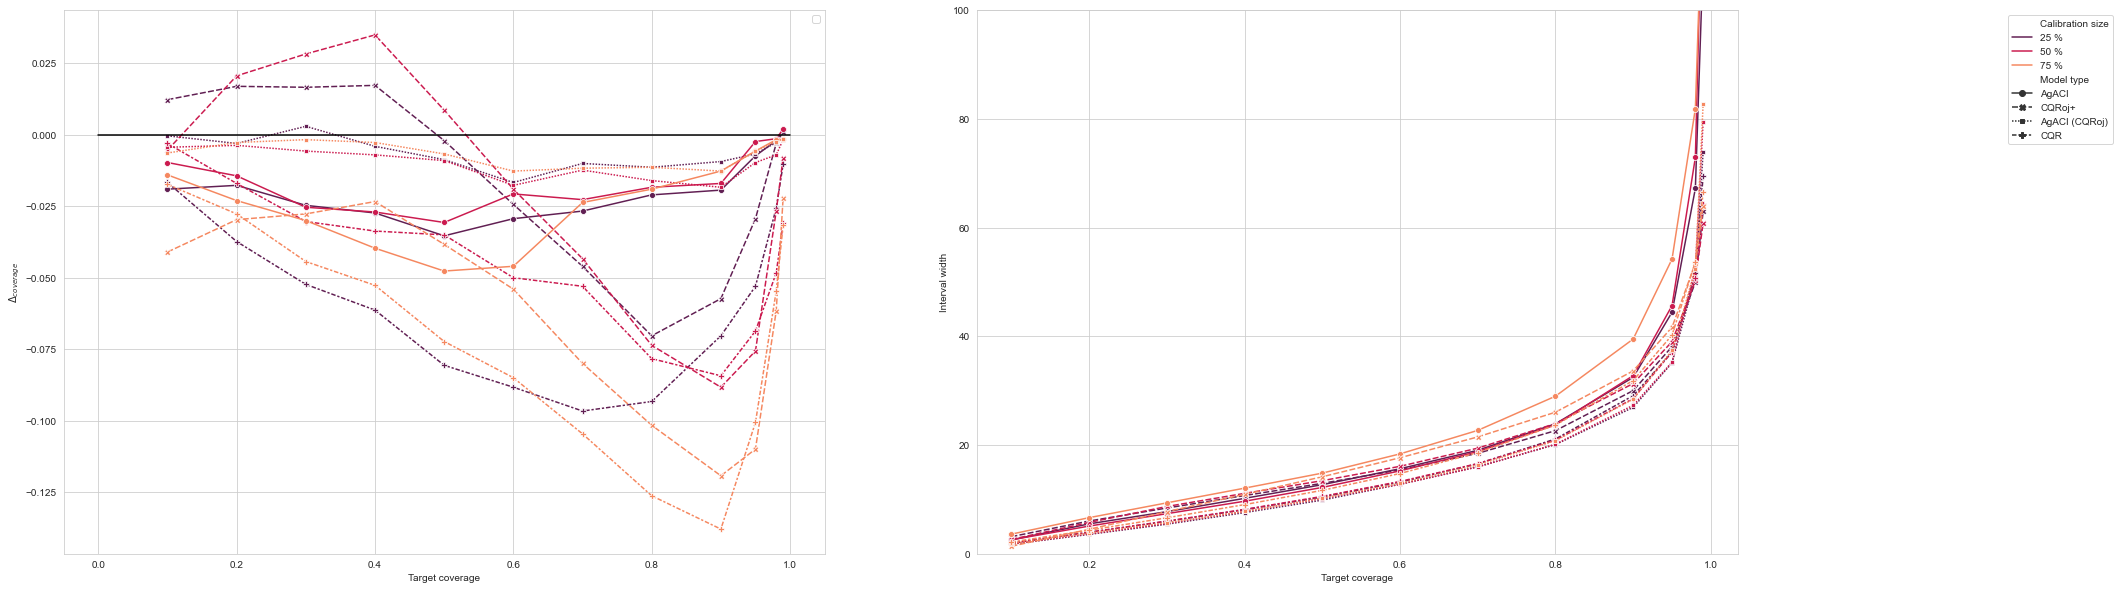

In [15]:

df_ = pd.read_csv('Data14.csv')
plot_quantile_pred_2(df_,
                    hue='Calibration size',
                                  style='Model type',
                                  palette=palette,
                                  ylim2 = (0, 100),)

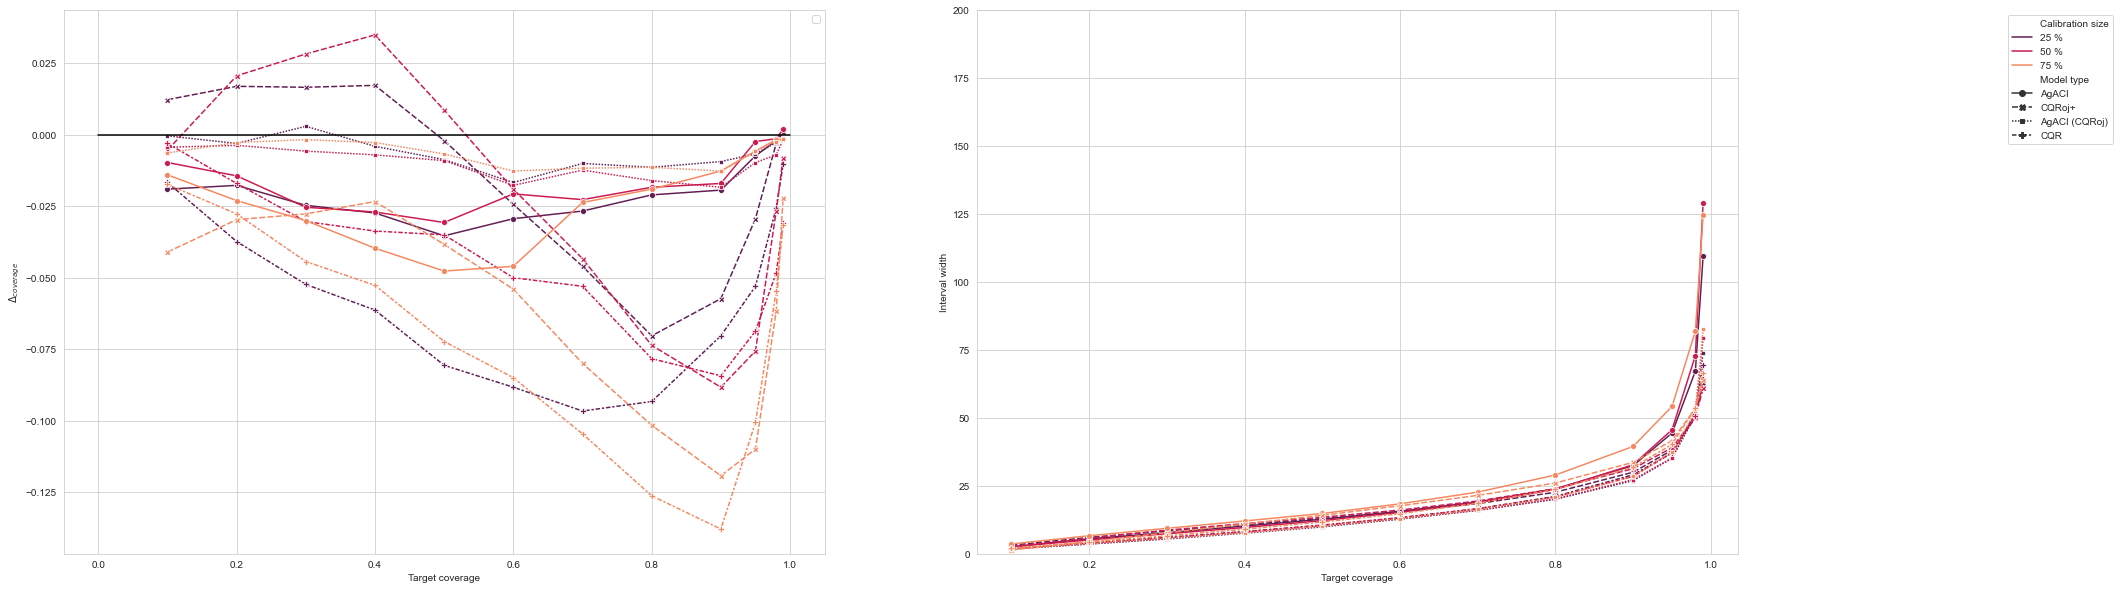

In [16]:
df_.to_csv('Data15.csv', index=False)
df_ = pd.read_csv('Data15.csv')
plot_quantile_pred_2(df_,
                    hue='Calibration size',
                                  style='Model type',
                                  palette=palette,
                                  ylim2 = (0, 200),)

# Graph 8 & 9

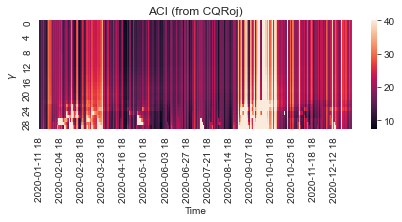

In [17]:

dfp = pd.read_csv('Data16.csv')

plt.figure(figsize = (7, 2))
fig = sns.heatmap(dfp, vmax = 40)
plt.xlabel('Time')
plt.ylabel('$\\gamma$')
a, ticks = plt.xticks()
plt.xticks(ticks = a[::2], labels = [ticks[i].get_text()[:13] for i in range(len(ticks))][::2])
plt.title('ACI (from CQRoj)')
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


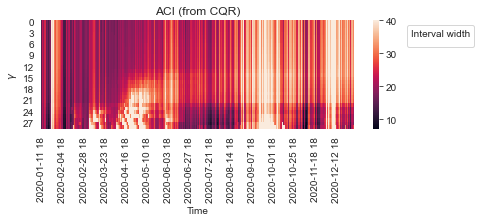

In [18]:

dfp2 = pd.read_csv('Data17.csv')

plt.figure(figsize = (7, 2))
fig = sns.heatmap(dfp2, vmax = 40)
plt.xlabel('Time')
plt.ylabel('$\\gamma$')
a, ticks = plt.xticks()
plt.xticks(ticks = a[::2], labels = [ticks[i].get_text()[:13] for i in range(len(ticks))][::2])
plt.title('ACI (from CQR)')
plt.legend(title='Interval width', loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()